Easy Steps to Access Kaggle Datasets in Colab https://medium.com/@opalkabert/downloading-kaggle-datasets-into-google-colab-fb9654c94235

# Importing packages and data preparation


In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"titocampos","key":"54050bc5fe24a0e561823e973e542607"}'}

In [2]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip -q chest-xray-pneumonia.zip
!unzip -q chest_xray.zip
!rm -rf chest-xray-pneumonia.zip
!rm -rf chest_xray.zip
!rm -rf __MACOSX
!rm -rf ~/.kaggle/

     |████████████████████████████████| 61kB 5.1MB/s 
 99% 1.14G/1.15G [00:22<00:00, 71.5MB/s]
100% 1.15G/1.15G [00:22<00:00, 55.7MB/s]


In [3]:
!pip install tensorflow-gpu==2.0.0-rc1

     |████████████████████████████████| 380.5MB 76kB/s 
     |████████████████████████████████| 501kB 29.4MB/s 
     |████████████████████████████████| 4.3MB 45.1MB/s 


In [4]:
import numpy as np
import os, math, json
from matplotlib import pyplot as plt
from PIL import Image
import tensorflow as tf
import glob
from skimage.transform import resize
from sklearn.utils.class_weight import compute_class_weight
AUTO = tf.data.experimental.AUTOTUNE
%matplotlib inline
print(tf.__version__)
print(tf.test.gpu_device_name())

2.0.0-rc1
/device:GPU:0


In [0]:
train_dir = './chest_xray/train/'
train_imgs_normal = glob.glob(train_dir + 'NORMAL/*.jpeg')
train_imgs_pneumo = glob.glob(train_dir + 'PNEUMONIA/*.jpeg')

val_dir = './chest_xray/val/'

test_dir = './chest_xray/test/'
test_imgs_normal = glob.glob(test_dir + 'NORMAL/*.jpeg')
test_imgs_pneumo = glob.glob(test_dir + 'PNEUMONIA/*.jpeg')

WIDTH = 150
HEIGHT = 150
BATCH_SIZE = 256
NUM_CLASSES = 2
CLASSES = ['NORMAL', 'PNEUMONIA']

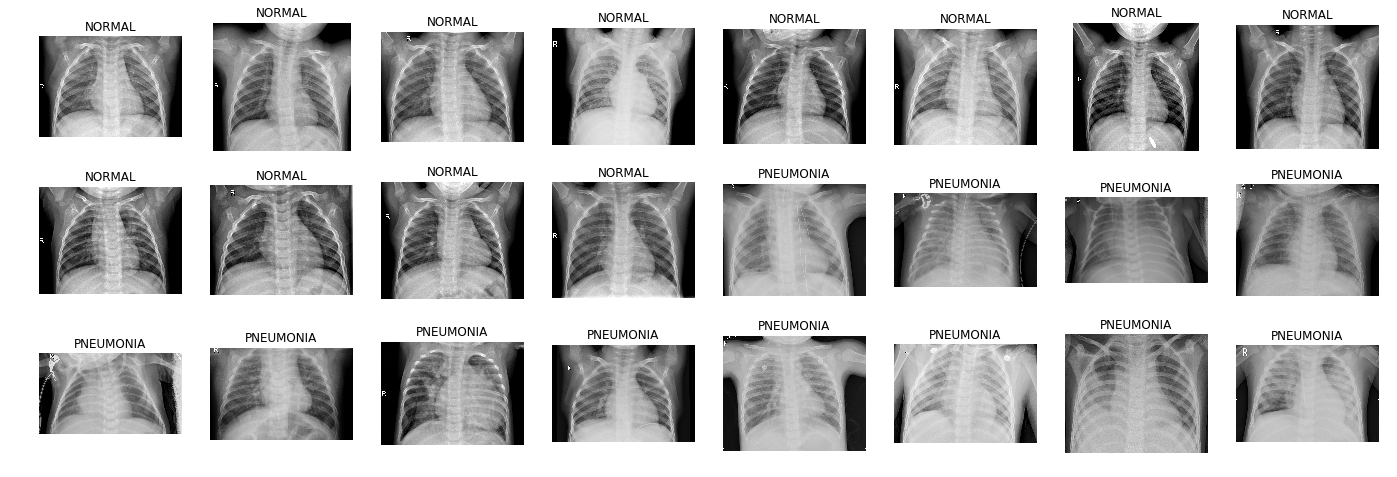

In [6]:
normal = np.random.choice(train_imgs_normal, 12)
pneumo = np.random.choice(train_imgs_pneumo, 12)
data = np.concatenate((normal, pneumo))
labels = 12 * [CLASSES[0]] + 12 * [CLASSES[1]]
R, C = 3, 8
plt.figure(figsize=(24, 8))
for k, (src, label) in enumerate(zip(data, labels)):
    im = Image.open(src).convert('RGB')
    plt.subplot(R, C, k+1)
    plt.title(label)
    plt.imshow(np.asarray(im))
    plt.axis('off')


# Data augmentation

In [7]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input,
                                                                  rotation_range=40,
                                                                  width_shift_range=0.2,
                                                                  height_shift_range=0.2,
                                                                  shear_range=0.2,
                                                                  zoom_range=0.2,
                                                                  horizontal_flip=True,
                                                                  fill_mode='nearest',
                                                                  validation_split = 0.35)

train_iterator = train_generator.flow_from_directory(train_dir,
                                                     target_size=(HEIGHT, WIDTH),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle = True, 
                                                     color_mode="rgb",
                                                     seed=42,
                                                     class_mode='binary',
                                                     subset = "training")


val_iterator = train_generator.flow_from_directory(train_dir, 
                                                   target_size=(HEIGHT, WIDTH),
                                                   batch_size=BATCH_SIZE,
                                                   shuffle = False, 
                                                   color_mode="rgb",
                                                   seed=42,
                                                   class_mode='binary',
                                                   subset = "validation")

Found 3391 images belonging to 2 classes.
Found 1825 images belonging to 2 classes.


# Model customization

In [8]:
base_model = tf.keras.applications.InceptionV3(weights = "imagenet", include_top = False, input_shape = (150, 150, 3))
base_model.trainable = False
              
myModel = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(name='avg_pool'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')])  
  
opt = tf.keras.optimizers.Adam(lr=1e-3, decay=1e-6)
myModel.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

myModel.summary()

87916544/87910968 [==============================] - 4s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 3, 3, 2048)        21802784  
_________________________________________________________________
avg_pool (GlobalAveragePooli (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________

In [9]:
EPOCHS = 10
STEPS_PER_EPOCH = train_iterator.n//train_iterator.batch_size
VALIDATION_STEPS = val_iterator.n//val_iterator.batch_size
MODEL_FILE = 'filename.model'

!rm -rf filename.model

history = myModel.fit_generator(
    train_iterator,
    epochs=EPOCHS,
    verbose = 1,
    workers = 20,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=val_iterator,
    validation_steps=VALIDATION_STEPS)
  
myModel.save(MODEL_FILE)

Epoch 1/10
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
13/13 [==============================] - 96s 7s/step - loss: 1.5624 - accuracy: 0.7604 - val_loss: 0.6047 - val_accuracy: 0.7377
Epoch 2/10
13/13 [==============================] - 88s 7s/step - loss: 0.6644 - accuracy: 0.6845 - val_loss: 0.5273 - val_accuracy: 0.7394
Epoch 3/10
13/13 [==============================] - 89s 7s/step - loss: 0.5951 - accuracy: 0.7324 - val_loss: 0.4709 - val_accuracy: 0.7712
Epoch 4/10
13/13 [==============================] - 87s 7s/step - loss: 0.4800 - accuracy: 0.7710 - val_loss: 0.5273 - val_accuracy: 0.7997
Epoch 5/10
13/13 [==============================] - 88s 7s/step - loss: 0.4208 - accuracy: 0.8099 - val_loss: 0.5735 - val_accuracy: 0.7768
Epoch 6/10
13/13 [==============================] - 88s 7s/step - loss: 0.3709 - accuracy: 0.8329 - val_loss: 0.8032 - val_accuracy: 0.8019
Epoch 7/10
13/13 [==============================] - 85s 7s/step - 

In [10]:
!zip -r modelo.zip filename.model 

  adding: filename.model/ (stored 0%)
  adding: filename.model/saved_model.pb (deflated 93%)
  adding: filename.model/assets/ (stored 0%)
  adding: filename.model/variables/ (stored 0%)
  adding: filename.model/variables/variables.data-00001-of-00002 (deflated 7%)
  adding: filename.model/variables/variables.data-00000-of-00002 (deflated 82%)
  adding: filename.model/variables/variables.index (deflated 77%)


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


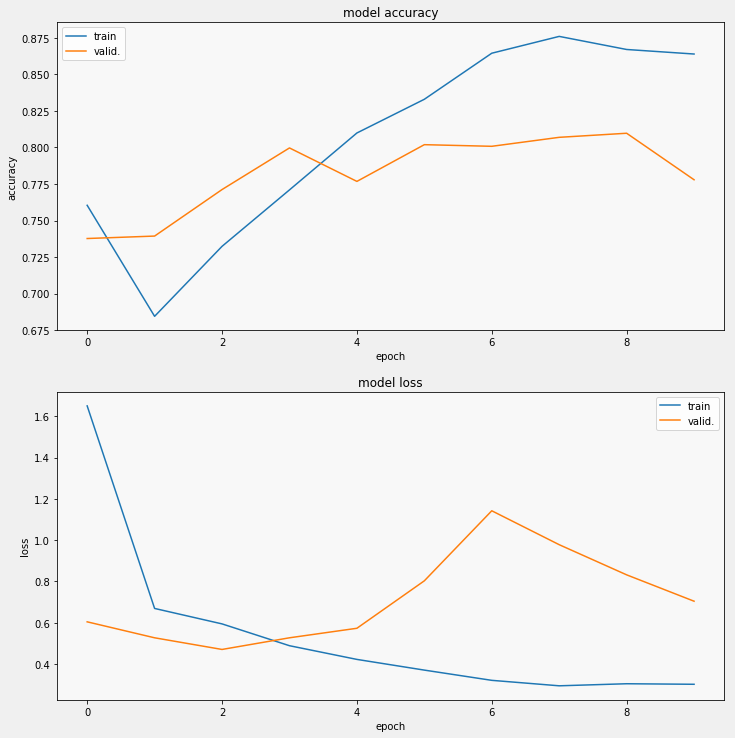

In [11]:
def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])
  
  
print(history.history.keys())
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

In [12]:
scores = myModel.evaluate_generator(generator=val_iterator, steps=VALIDATION_STEPS, verbose=1)
print("%s: %.2f%%" % (myModel.metrics_names[1], scores[1]*100))

7/7 [==============================] - 32s 5s/step - loss: 0.6977 - accuracy: 0.7773
accuracy: 77.73%


In [0]:
def predict(model, img):
    x = tf.keras.preprocessing.image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = tf.keras.applications.inception_v3.preprocess_input(x)
    preds = model.predict(x, steps=1)
    return preds
  
def plot_prediction(R, C, K, im, title, black=False):
    plt.subplot(R, C, K)
    plt.axis('off')
    plt.title(title, fontsize=12, color='black' if black else 'red')
    plt.imshow(np.asarray(im))


accuracy: 75.00%


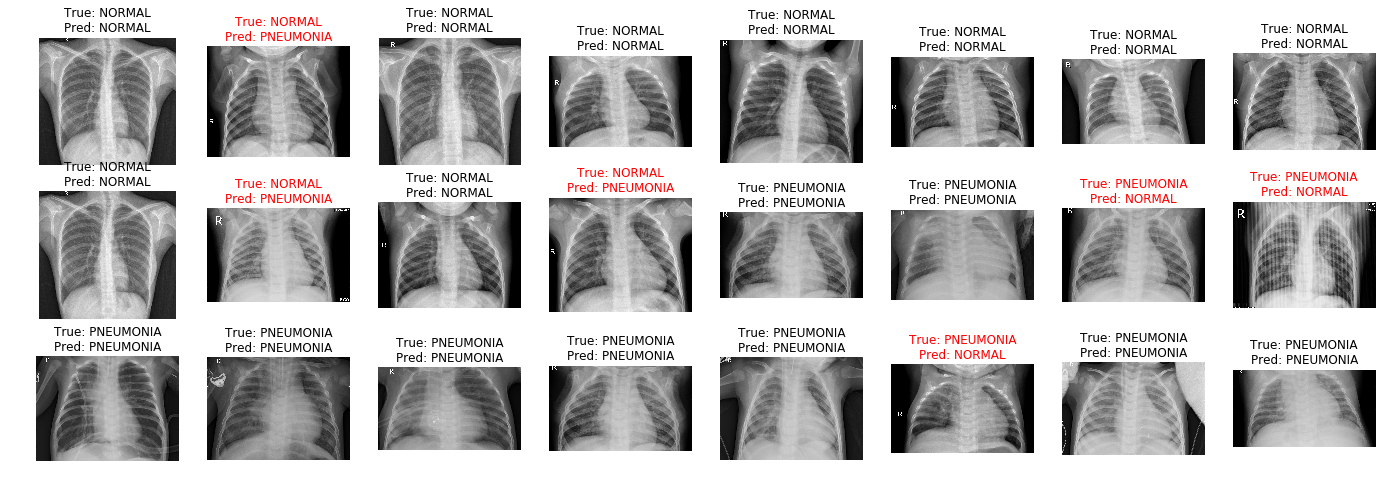

In [14]:
np.random.seed(42)
normal = np.random.choice(test_imgs_normal, 12)
np.random.seed(42)
pneumo = np.random.choice(test_imgs_pneumo, 12)
data = np.concatenate((normal, pneumo))
labels = 12 * [CLASSES[0]] + 12 * [CLASSES[1]]
R, C = 3, 8
acc = 0
plt.figure(figsize=(24, 8))
for k, (src, label) in enumerate(zip(data, labels)):
    img = tf.keras.preprocessing.image.load_img(src, target_size=(150, 150))
    preds = predict(myModel, img)
    pred_label = np.array(CLASSES)[np.argmax(preds, axis=-1)].tolist()[0]
    acc += 1 if pred_label == label else 0
    title = ("%s%s%s%s%s"%("True: ", label, "\n", "Pred: ", pred_label))
    im = Image.open(src).convert('RGB')
    plot_prediction(R, C, k+1, im, title, pred_label == label)

print('accuracy: {:05.2f}%'.format(acc / 24.0 * 100))    
    